## Define Area of Interest (AOI)

Use the map below to draw a rectangle defining your processing area. The maximum size is approximately 600x600 pixels at 10m resolution.

In [1]:
import openeo
from pathlib import Path
import config
print(config.CRS)

EPSG:32630


In [2]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

UDPdir = Path('C:/Git_projects/WAC/classification/UDP/')

generate_udp(conn=connection,
    build_pipeline_fn = create_classification_cube,  # <-- pass function, not result
    process_id =  'WAC_inference_asia',
    summary = 'WAC_inference_asia',
    output_dir = UDPdir)

Authenticated using refresh token.


NameError: name 'generate_udp' is not defined

In [ ]:
from geospatial_pipeline.input_cube_loader import load_input_cube
from geospatial_pipeline.band_normalization import normalize_cube
from geospatial_pipeline.onnx_inference import run_inference


connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()


cube = load_input_cube(
        connection,
        spatial_extent=config.SPATIAL_EXTENT,
        temporal_extent=config.TEMPORAL_EXTENT,
        max_cloud_cover=config.MAX_CLOUD_COVER,
        resolution=config.RESOLUTION,
        crs=config.CRS
    )

cube_normalised = normalize_cube(cube)

# Run inference
inference_cube = run_inference(
    cube_normalised,
    model_name=config.MODEL_NAME,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE
)

save_inference_cube = inference_cube.save_result(format = "netCDF")
save_inference_cube


Authenticated using refresh token.


In [4]:
job = connection.create_job(save_inference_cube,
    additional=config.JOB_OPTIONS
)
job.start_and_wait()

0:00:00 Job 'j-2508220755374325aa75e8b80f3339a8': send 'start'
0:00:14 Job 'j-2508220755374325aa75e8b80f3339a8': created (progress 0%)
0:00:19 Job 'j-2508220755374325aa75e8b80f3339a8': created (progress 0%)
0:00:26 Job 'j-2508220755374325aa75e8b80f3339a8': created (progress 0%)
0:00:34 Job 'j-2508220755374325aa75e8b80f3339a8': queued (progress 0%)
0:00:44 Job 'j-2508220755374325aa75e8b80f3339a8': queued (progress 0%)
0:00:57 Job 'j-2508220755374325aa75e8b80f3339a8': queued (progress 0%)
0:01:13 Job 'j-2508220755374325aa75e8b80f3339a8': queued (progress 0%)
0:01:32 Job 'j-2508220755374325aa75e8b80f3339a8': queued (progress 0%)
0:01:56 Job 'j-2508220755374325aa75e8b80f3339a8': queued (progress 0%)
0:02:26 Job 'j-2508220755374325aa75e8b80f3339a8': queued (progress 0%)
0:03:03 Job 'j-2508220755374325aa75e8b80f3339a8': running (progress N/A)
0:03:50 Job 'j-2508220755374325aa75e8b80f3339a8': running (progress N/A)
0:04:49 Job 'j-2508220755374325aa75e8b80f3339a8': running (progress N/A)
0:05:

<BatchJob job_id='j-2508220755374325aa75e8b80f3339a8'>

In [5]:
import xarray as xr


output_dir = "C:\\Git_projects\\WAC\\classification\\test_reference\\" + job.job_id
path = job.get_results().download_files(f"{output_dir}")
ds = xr.open_dataset(path[0])
ds


<xarray.Dataset> Size: 568MB
Dimensions:         (t: 1, x: 1618, y: 1688)
Coordinates:
  * t               (t) datetime64[ns] 8B 2023-01-01
  * x               (x) float64 13kB 7.162e+05 7.162e+05 ... 7.324e+05 7.324e+05
  * y               (y) float64 14kB 6.224e+05 6.224e+05 ... 6.055e+05 6.055e+05
Data variables: (12/27)
    crs             |S1 1B ...
    prob_class_0    (t, y, x) float64 22MB ...
    prob_class_1    (t, y, x) float64 22MB ...
    prob_class_2    (t, y, x) float64 22MB ...
    prob_class_3    (t, y, x) float64 22MB ...
    prob_class_4    (t, y, x) float64 22MB ...
    ...              ...
    prob_class_20   (t, y, x) float64 22MB ...
    prob_class_21   (t, y, x) float64 22MB ...
    prob_class_22   (t, y, x) float64 22MB ...
    prob_class_23   (t, y, x) float64 22MB ...
    prob_class_24   (t, y, x) float64 22MB ...
    classification  (t, y, x) float64 22MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.67.0a7.dev20...
    description:  
    title:

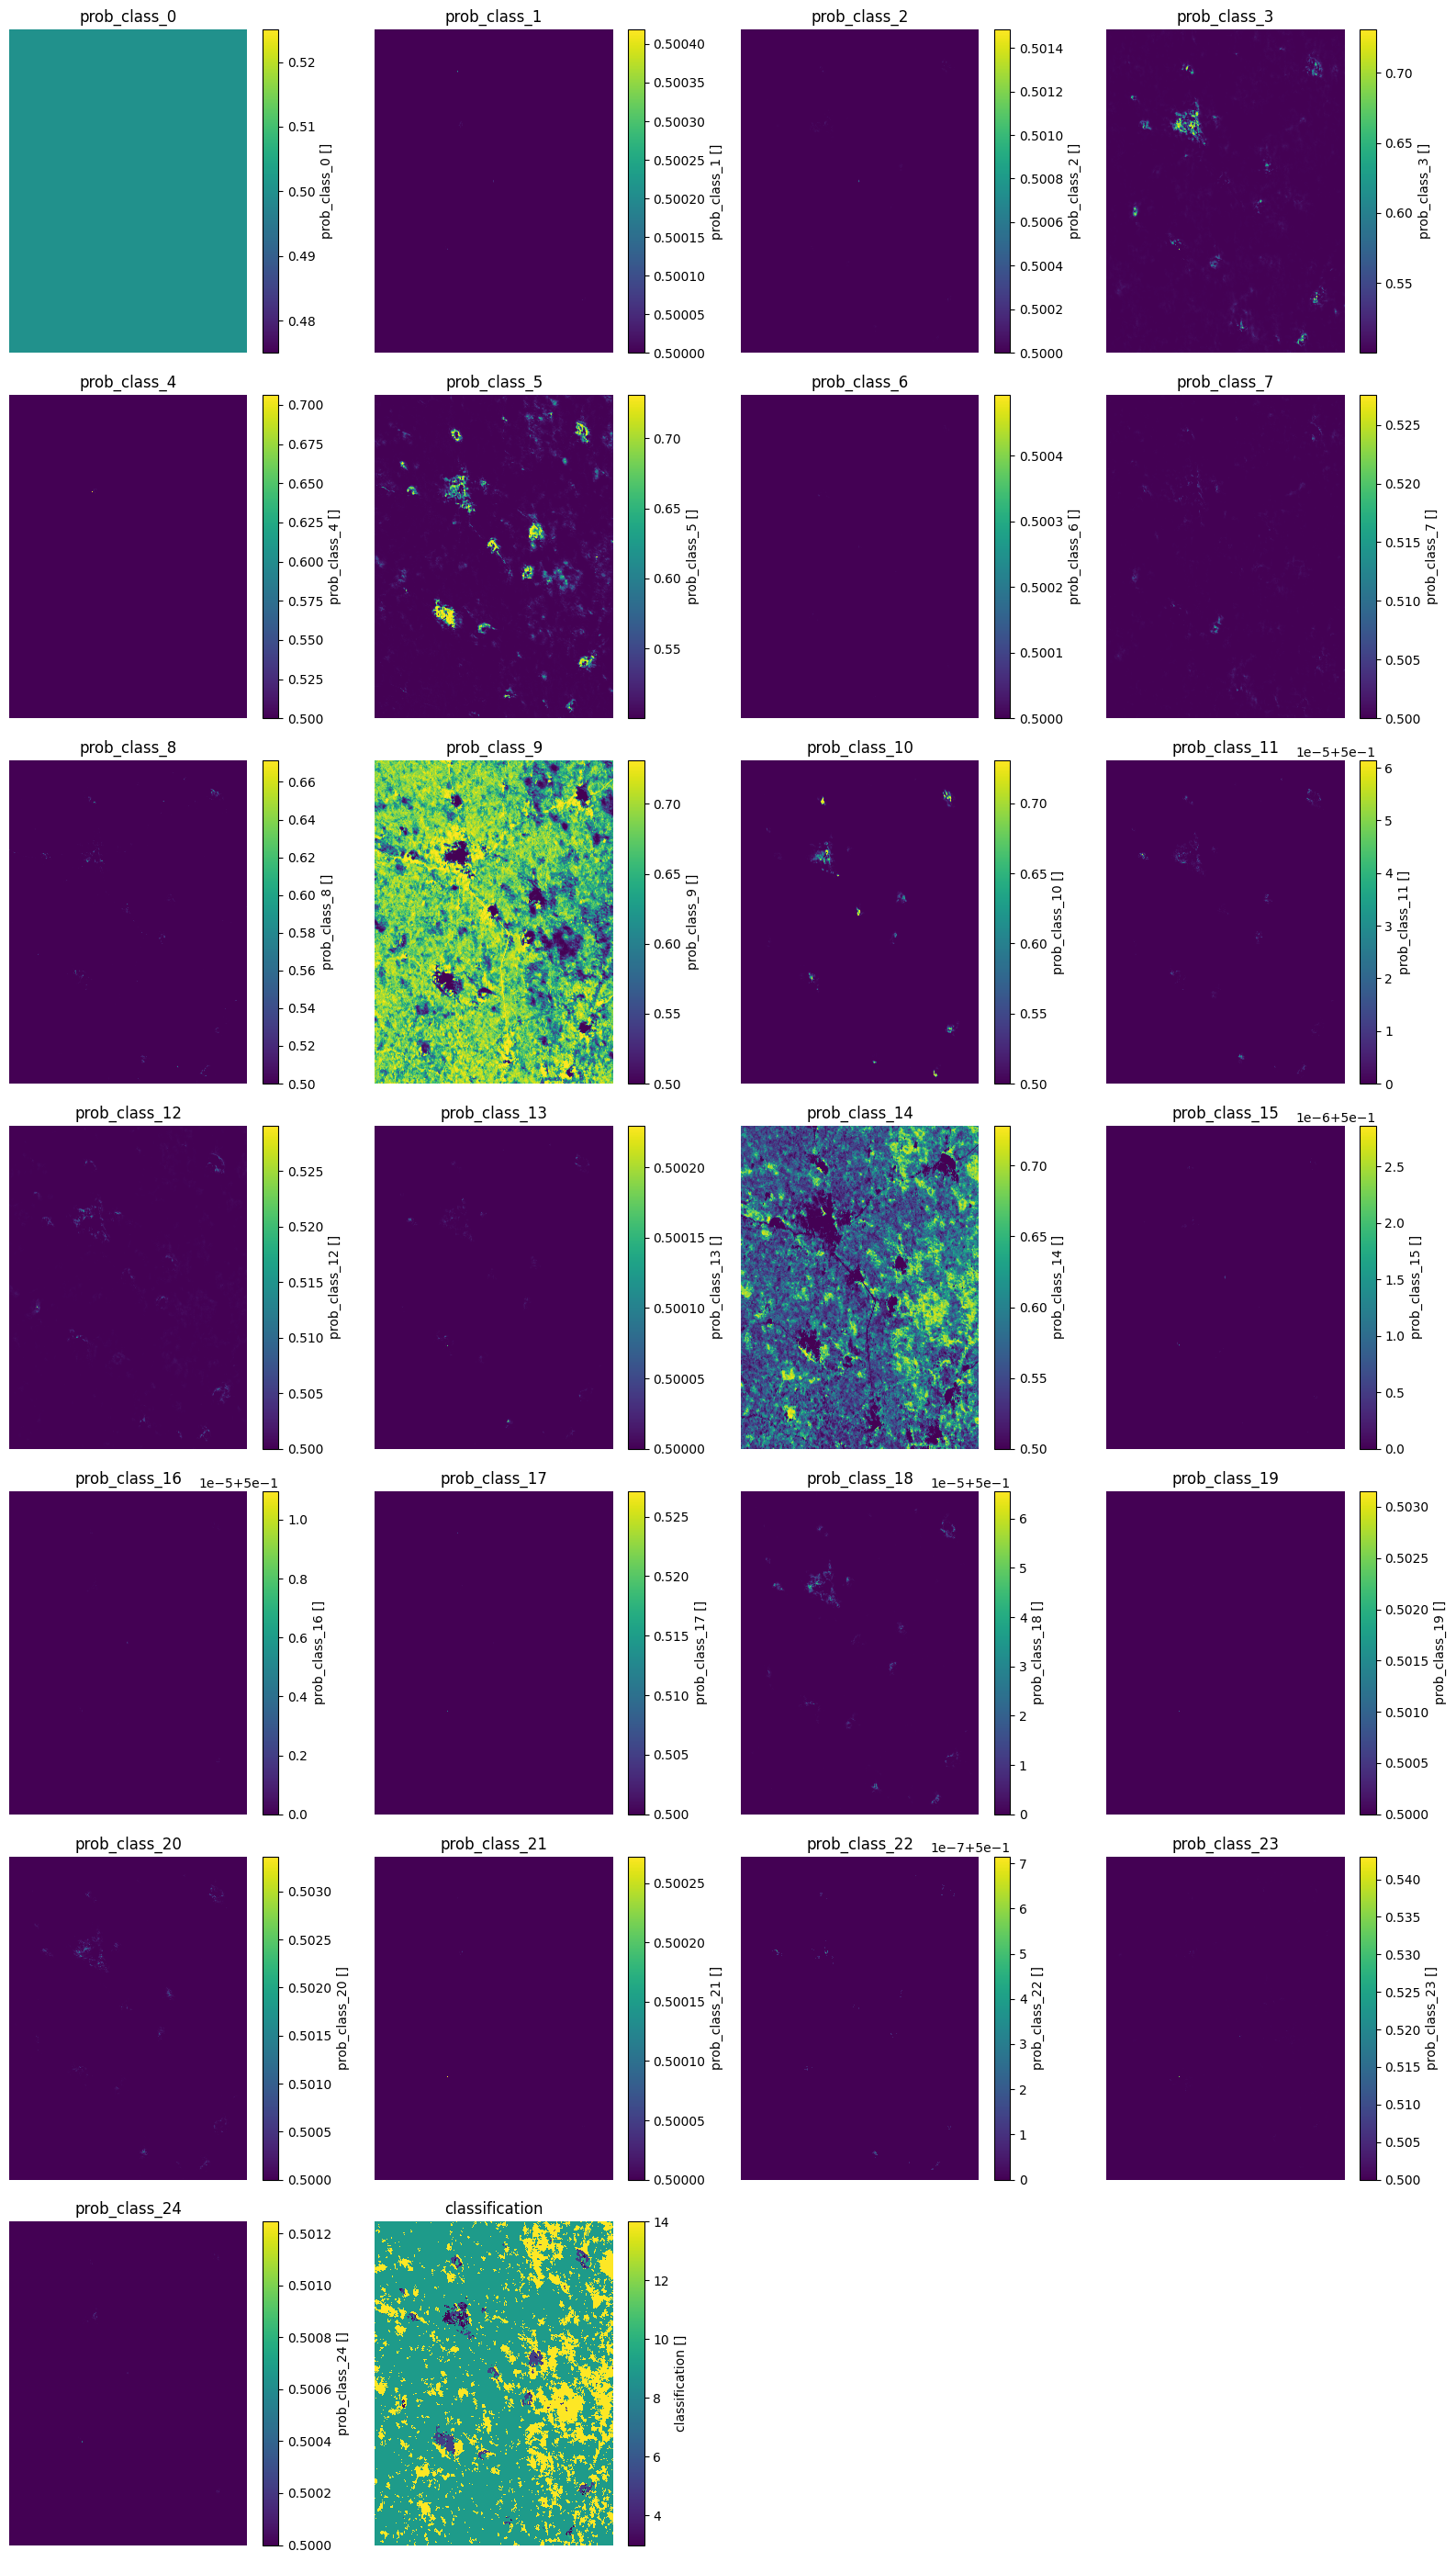

In [6]:

import matplotlib.pyplot as plt

time_step = 0
# Load dataset


# Filter only variables with dimensions (t, y, x)
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

n = len(variables_to_plot)
ncols = 4  # adjust based on how wide you want the figure
nrows = -(-n // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for i, var in enumerate(variables_to_plot):
    data = ds[var].isel(t=time_step)

    ax = axes.flat[i]
    data.plot(ax=ax, add_colorbar=True)
    ax.set_title(var)
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes.flat)):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()



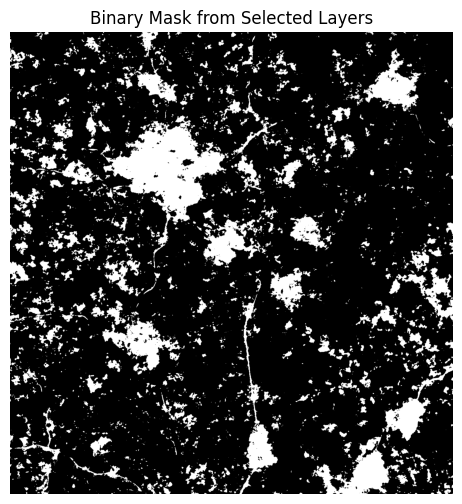

In [27]:
import numpy as np
import matplotlib.pyplot as plt

time_step = 0
# Example list of indices for layers you want to use
layer_indices = [5, 6, 8, 9]  # change this to your desired layers

# Filter variables with dimensions (t, y, x)
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

# Function to normalize data to [0, 1]
def normalize(data):
    return (data - data.min()) / (data.max() - data.min()) if data.max() != data.min() else data * 0

# Collect normalized layers
layers = []
for i in layer_indices:
    var = variables_to_plot[i]
    data = ds[var].isel(t=time_step)
    layers.append(normalize(data))

# Sum and renormalize
summed = sum(layers)
summed_norm = normalize(summed)

# Create binary mask using a threshold
threshold = 0.025  # you can adjust this
binary_mask = (summed_norm > threshold).astype(int)

# Plot result
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask from Selected Layers")
plt.axis('off')
plt.show()
